# MODELING

In [1]:
# Imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import re
import pickle

# NLP import
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Pipeline
from sklearn.pipeline import Pipeline

# Machine Learning
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

In [8]:
df = pd.read_csv('../datasets/train_cleaned.csv')

df.head()

,positive,text
0,1,bromwell high is a cartoon comedy it ran at th...
1,1,homelessness or houselessness as george carlin...
2,1,brilliant over acting by lesley ann warren bes...
3,1,this is easily the most underrated film inn th...
4,1,this is NOTthe typical mel brooks film it was ...


In [9]:
np.random.seed(42)

In [17]:
# Classification score and confusion matrix 
def evaluation(actual, pred, title = 'Confusion Matrix'):
    cm = confusion_matrix(actual, pred)
    precision = precision_score(actual, pred)
    recall = recall_score(actual, pred)
    accuracy = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred)
    roc_auc = roc_auc_score(actual, pred)
    
    print('TEST:')
    print('Accuracy: ', accuracy)
    print('\nRecall: ', recall)
    print('Precision: ', precision)
    print('F1: ', f1)
    print('ROC_AUC: ', roc_auc)
    
    sns.heatmap(cm, cmap= 'cividis', annot=True, fmt='g', annot_kws={'size':20},
                vmin=0, vmax=len(actual))
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

In [11]:
# Pipeline method (also calls the evalation() method within)
def pipe(vectorizer, model):
    #Pipeline vectorizer + estimator
    pipe = Pipeline([
        ('vec', vectorizer),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    
    train_score = pipe.score(X_train,y_train)
    pred = pipe.predict(X_test) 

    print('TRAINING:')
    print(f'Accuracy: {train_score}')
    print()
    evaluation(y_test, pred) # output values

In [12]:
# Feature and Target defined
y = df['positive']
X = df['text']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

### PRELIMINARY MODEL COMPARISONS -- ACCURACY

In [7]:
# Dictionary of all models for iteration
models = {
    'Logistic Regression':LogisticRegression(solver='liblinear'),
    'KNN':KNeighborsClassifier(),
    'BernoulliNB': BernoulliNB(),
    'MultinomialNB': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
#     'SVC': SVC(random_state=42),
    'AdaBoosting': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
#     'OneVsRest': OneVsRestClassifier(n_jobs=-1)
}

# Iteration to generate 5-fold cross-valuation scores for each default model
print('(TFIDF) DEFAULT SCORE COMPARISON')
for name, model in models.items():
    pipe = Pipeline([
        ('vec', TfidfVectorizer(stop_words='english')),
        ('model', model)
    ])
    
    cv_score = cross_val_score(pipe, X_train, y_train, cv=5, n_jobs=-1).mean()
    print(f'{name}: {cv_score}')
    
    
    
# (TFIDF) DEFAULT SCORE COMPARISON
# Logistic Regression: 0.8894500000000001
# KNN: 0.6014
# BernoulliNB: 0.8492000000000001
# MultinomialNB: 0.8689500000000001
# Random Forest: 0.85625
# AdaBoosting: 0.80135
# XGBoost: 0.8481500000000001

(TFIDF) DEFAULT SCORE COMPARISON
Logistic Regression: 0.8894500000000001
KNN: 0.6014
BernoulliNB: 0.8492000000000001
MultinomialNB: 0.8689500000000001
Random Forest: 0.85625
AdaBoosting: 0.80135
XGBoost: 0.8481500000000001


In [8]:
print('(COUNT) DEFAULT SCORE COMPARISON')
for name, model in models.items():
    pipe = Pipeline([
        ('vec', CountVectorizer(stop_words='english')),
        ('model', model)
    ])
    
    cv_score = cross_val_score(pipe, X_train, y_train, cv=5, n_jobs=-1).mean()
    print(f'{name}: {cv_score}')
    
    
    
# (COUNT) DEFAULT SCORE COMPARISON
# Logistic Regression: 0.8784000000000001
# KNN: 0.5847999999999999
# BernoulliNB: 0.8492000000000001
# MultinomialNB: 0.8606499999999999
# Random Forest: 0.85815
# AdaBoosting: 0.79885
# XGBoost: 0.8548500000000001

(COUNT) DEFAULT SCORE COMPARISON
Logistic Regression: 0.8784000000000001
KNN: 0.5847999999999999
BernoulliNB: 0.8492000000000001
MultinomialNB: 0.8606499999999999
Random Forest: 0.85815
AdaBoosting: 0.79885
XGBoost: 0.8548500000000001


## Logistic Regression + TfidVectorizer has the best accuracy:
- 0.8894500000000001
- We'll take a look at ROC_AUC as well as separability performance is very important for accurate sentiment analysis

### PRELIMINARY MODEL COMPARISONS -- AREA UNDER ROC

In [9]:
print('(TFIDF) DEFAULT ROC_AUC COMPARISON')
for name, model in models.items():
    pipe = Pipeline([
        ('vec', TfidfVectorizer(stop_words='english')),
        ('model', model)
    ])
    
    cv_score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc',
                               n_jobs=-1).mean()
    print(f'{name}: {cv_score}')
    
    
    
# (TFIDF) DEFAULT ROC_AUC COMPARISON
# Logistic Regression: 0.9565836750000001
# KNN: 0.6832488250000001
# BernoulliNB: 0.9286413750000001
# MultinomialNB: 0.9419070250000001
# Random Forest: 0.9313566000000002
# AdaBoosting: 0.880548825
# XGBoost: 0.9268192000000001

(TFIDF) DEFAULT ROC_AUC COMPARISON
Logistic Regression: 0.9565836750000001
KNN: 0.6832488250000001
BernoulliNB: 0.9286413750000001
MultinomialNB: 0.9419070250000001
Random Forest: 0.931356325
AdaBoosting: 0.880548825
XGBoost: 0.9268192000000001


In [10]:
print('(COUNT) DEFAULT ROC_AUC COMPARISON')
for name, model in models.items():
    pipe = Pipeline([
        ('vec', CountVectorizer(stop_words='english')),
        ('model', model)
    ])
    
    cv_score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc',
                               n_jobs=-1).mean()
    print(f'{name}: {cv_score}')
    
    
    
# (COUNT) DEFAULT ROC_AUC COMPARISON
# Logistic Regression: 0.9446618249999998
# KNN: 0.6227359
# BernoulliNB: 0.9286413750000001
# MultinomialNB: 0.9270035
# Random Forest: 0.9313948
# AdaBoosting: 0.87991985
# XGBoost: 0.9296018500000001

(COUNT) DEFAULT ROC_AUC COMPARISON
Logistic Regression: 0.9446598749999999
KNN: 0.6227359
BernoulliNB: 0.9286413750000001
MultinomialNB: 0.9270035
Random Forest: 0.9313936999999999
AdaBoosting: 0.87991985
XGBoost: 0.9296018500000001


## Logistic Regression + TfidVectorizer has the best ROC_AUC as well:
- 0.9565836750000001

## TUNING LOGREG

In [11]:
# GridSearchCV method (also calls the evalation() method within)
def grid(vectorizer, model, params, cv=3):
    #Grid Search on Pipeline of vectorizer + estimator
    grid = GridSearchCV(Pipeline([('vec', vectorizer),
                                  ('model', model)]),
                        params,
                        cv=cv,
                        verbose=1,
                        n_jobs=-1)
    
    # Fit on training
    grid.fit(X_train, y_train)
    
    # Extact best estimators & refit on training
    best = grid.best_estimator_
    best.fit(X_train, y_train)
    
    best_score = best.score(X_train, y_train)
    pred = best.predict(X_test) 
    
    print('TRAINING:')
    print(f'Accuracy: {best_score}')
    print()
    evaluation(y_test, pred) # output values
    print(f'\nBEST PARAMETERS: {grid.best_params_}\n')
    
    return grid.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
TRAINING:
Accuracy: 0.945

TEST:
Accuracy:  0.8828

Recall:  0.8976
Precision:  0.8717948717948718
F1:  0.8845092629089475
ROC_AUC:  0.8828


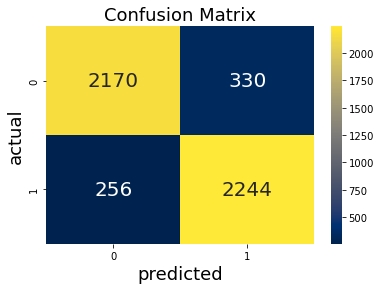


BEST PARAMETERS: {'model__penalty': 'l2', 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}



In [12]:
params = {
    'vec__stop_words':[None, 'english'],
#     'vec__max_features':[None, 2000, 5000],
#     'vec__min_df':[None, 0.05, 0.1],
#     'vec__max_df':[None, 0.8, 0.9],
    'vec__ngram_range':[(1,1), (1,2)],
    'model__penalty':['l1', 'l2']
}

best_lr = grid(TfidfVectorizer(), LogisticRegression(solver='liblinear'), params, cv=5)

## RESULTS SAVED IN-CASE
    # Fitting 5 folds for each of 8 candidates, totalling 40 fits
    # TRAINING:
    # Accuracy: 0.945

    # TEST:
    # Accuracy:  0.8828

    # Recall:  0.8976
    # Precision:  0.8717948717948718
    # F1:  0.8845092629089475
    # ROC_AUC:  0.8828

    # BEST PARAMETERS: {'model__penalty': 'l2', 'vec__ngram_range': (1, 1), 'vec__stop_words': 'english'}

## RESULTS:
- Turns out almost-default parameters worked best:
    - Train/Test Accuracy: 0.945/0.8828
    - Test AUC: 0.8828
- TF-IDF
    - stop_words = 'english'
    - ngram_range = (1,1)
- Logistic Regression
    - penalty = 'l2'
    - solver = 'liblinear'

In [18]:
# Store best logisitic regression + TF-IDF pipe fit for future preprocessing
best_lr.fit(X_train, y_train)

# Saved
with open('logreg_tfidf.pickle', 'wb') as handle:
    pickle.dump(best_lr, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
## Can be loaded for future use:
    ## from sklearn.linear_model import LogisticRegression
    ## import pickle
    ##
    ## with open('logreg_tfidf.pickle', 'rb') as handle:
    ##     lr = pickle.load(handle)

In [13]:
# Score confirmation
pred = best_lr.predict(X_test)

print(classification_report(y_test, pred))
print('AUC: ', round(roc_auc_score(y_test, pred), 2))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2500
           1       0.87      0.90      0.88      2500

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000

AUC:  0.88


**TEST RUN FOR WEBAPP**

In [10]:
def sentiment(text):
    with open('logreg_tfidf.pickle', 'rb') as handle:
        lr = pickle.load(handle)

    prediction = lr.predict([text])[0]
    
    if prediction:
        return f'"{text}" : POSITIVE'
    else:
        return f'"{text}" : NEGATIVE'

In [11]:
# SAMPLE TEST    
print(sentiment('That movie was horrendous. It was full of plot holes and made no sense.'))
print(sentiment('That movie was wonderful. It was action-packed and very engaging.'))

"That movie was horrendous. It was full of plot holes and made no sense." : NEGATIVE
"That movie was wonderful. It was action-packed and very engaging." : POSITIVE


## NEURAL NETWORK

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Embedding, BatchNormalization, Dropout, AveragePooling1D, GlobalAveragePooling1D, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [74]:
# Max words in tokenizer index
max_words = 100000

# Tokenizer fit, sequenced, padded
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(train_seq, maxlen=300)
X_test_padded = pad_sequences(test_seq, maxlen=X_train_padded.shape[1])

# Word index stored for embedding matrix
word_index = tokenizer.word_index

# Dimensions for embedding matrix
embedding_dim = 300
vocab_size = min(len(word_index)+1, max_words)

# Saved neural tokenizer
with open('tokenizer/cnn_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
# GENSIM IMPORT ON GOOGLE PRETRAINED WORD2VEC
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')
    # If you have the physical .bin file downloaded:
        # wv = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

    # Empty matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Tracking unrecognized words
unknown = []

# Iterate through fitted word index and
# extract weighted vectors from pretrained Google word vector
for word, index in word_index.items():
    if index >= max_words:
        continue
    try:
        embedding_vector = wv[word] # extract word vector
        embedding_matrix[index] = embedding_vector # store word vector
    except:
        unknown.append(word)

In [17]:
# Unrecognized words
print(len(unknown))

# 20 random unrecognized words
np.random.choice(unknown, 20)

28270


array(['notwalk', 'bacharach', 'notattracting', 'nolawrence', '35yr',
       'darstardy', 'delbert', 'toussaint', 'mcinnerny', 'fownd',
       'teshigahara', 'huk', 'cedrac', 'extremal', 'superfighters',
       'notother', 'calhoun', '1938', 'margareta', 'notmonuments'],
      dtype='<U51')

In [18]:
# Model
model = Sequential()

# Embedding input
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                   trainable=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# 1 CNN layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(AveragePooling1D())
model.add(Dropout(0.25))

# 1 CNN layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.25))

# # 1 RNN layer
# model.add(Bidirectional(LSTM(64)))
# model.add(BatchNormalization())

# 1 Dense layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Sigmoid output
model.add(Dense(1, activation='sigmoid'))


# Model Compiled
model.compile(loss='binary_crossentropy',
             optimizer='SGD',
             metrics=['acc'])

# Summary
model.summary()

2022-02-22 16:58:55.110329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 16:58:55.163399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 16:58:55.163555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 16:58:55.164676: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         22342800  
                                                                 
 batch_normalization (BatchN  (None, None, 300)        1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, None, 300)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          28832     
                                                                 
 batch_normalization_1 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 average_pooling1d (AverageP  (None, None, 32)         0

2022-02-22 16:58:55.838064: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89371200 exceeds 10% of free system memory.


In [19]:
# Early stop 25 epochs after lowest validation, best weights restored
early = EarlyStopping(monitor='val_loss', patience=25, min_delta = 0.0001, restore_best_weights=True)

# Store best weights for future use without re-training
filepath = "weights/weights-improvement-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, mode='min', save_weights_only=True)

history = model.fit(X_train_padded, y_train,
                    validation_data=(X_test_padded, y_test),
                    batch_size=64,
                    epochs=200,
                    callbacks=[early, checkpoint],
                    verbose=1)

Epoch 1/200


2022-02-22 16:58:57.749007: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-02-22 16:58:59.441580: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - ETA: 0s - loss: 0.7181 - acc: 0.6194

2022-02-22 16:59:02.689860: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89371200 exceeds 10% of free system memory.
2022-02-22 16:59:02.820511: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89371200 exceeds 10% of free system memory.


313/313 [==============================] - 7s 10ms/step - loss: 0.7181 - acc: 0.6194 - val_loss: 0.6248 - val_acc: 0.7566
Epoch 2/200
 12/313 [>.............................] - ETA: 1s - loss: 0.5937 - acc: 0.6862

2022-02-22 16:59:02.958209: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89371200 exceeds 10% of free system memory.


309/313 [============================>.] - ETA: 0s - loss: 0.5265 - acc: 0.7435

2022-02-22 16:59:04.944820: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89371200 exceeds 10% of free system memory.


313/313 [==============================] - 2s 7ms/step - loss: 0.5257 - acc: 0.7437 - val_loss: 0.4209 - val_acc: 0.8232
Epoch 3/200
313/313 [==============================] - 2s 7ms/step - loss: 0.4646 - acc: 0.7876 - val_loss: 0.4452 - val_acc: 0.7756
Epoch 4/200
313/313 [==============================] - 3s 9ms/step - loss: 0.4340 - acc: 0.8045 - val_loss: 0.3887 - val_acc: 0.8270
Epoch 5/200
313/313 [==============================] - 2s 7ms/step - loss: 0.4126 - acc: 0.8177 - val_loss: 0.3960 - val_acc: 0.8120
Epoch 6/200
313/313 [==============================] - 3s 9ms/step - loss: 0.4045 - acc: 0.8203 - val_loss: 0.3420 - val_acc: 0.8578
Epoch 7/200
313/313 [==============================] - 2s 7ms/step - loss: 0.3921 - acc: 0.8281 - val_loss: 0.3572 - val_acc: 0.8440
Epoch 8/200
313/313 [==============================] - 2s 6ms/step - loss: 0.3855 - acc: 0.8302 - val_loss: 0.3382 - val_acc: 0.8566
Epoch 9/200
313/313 [==============================] - 2s 6ms/step - loss: 0.3786

## RESULTS
- Based on lowest lost
    - Epoch 96/200 - 2s 6ms/step - loss: 0.2628 - **acc: 0.8919** - val_loss: 0.2740 - **val_acc: 0.8942**


In [26]:
# Reload best weight
model.load_weights('weights/weights-improvement-96-0.2740.hdf5')

# Saved model for re-use (web-app)
model.save('model/sentiment_model.hdf5')

In [27]:
# Score confirmation
pred = (model.predict(X_test_padded)>0.5).astype(int)

print(classification_report(y_test, pred))
print('AUC: ', round(roc_auc_score(y_test, pred), 2))


# RESULTS SAVED
    #               precision    recall  f1-score   support

    #            0       0.92      0.87      0.89      2500
    #            1       0.87      0.92      0.90      2500

    #     accuracy                           0.89      5000
    #    macro avg       0.90      0.89      0.89      5000
    # weighted avg       0.90      0.89      0.89      5000

    # AUC:  0.89

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      2500
           1       0.87      0.92      0.90      2500

    accuracy                           0.89      5000
   macro avg       0.90      0.89      0.89      5000
weighted avg       0.90      0.89      0.89      5000

AUC:  0.89


**BETTER RESULTS THAN LOGISTIC REGRESSION + TF-IDF VECTORIZATION**

# TRANSFORMERS MODEL -- BART (BIDIRECTIONAL AUTOREGRESSIVE TRANSFORMER)

In [18]:
import transformers
from transformers import pipeline

### PRE-TRAINED BART MODEL FROM FACEBOOK
- https://huggingface.co/facebook/bart-large-mnli
- Trained on MultiNLI
    - The Multi-Genre Natural Language Inference (MultiNLI) corpus is a crowd-sourced collection of 433k sentence pairs annotated with textual entailment information. The corpus is modeled on the SNLI corpus, but differs in that covers a range of genres of spoken and written text, and supports a distinctive cross-genre generalization evaluation. The corpus served as the basis for the shared task of the RepEval 2017 Workshop at EMNLP in Copenhagen.



In [8]:
# # from transformers import BartTokenizer, BartForConditionalGeneration, AutoTokenizer, AutoModelForSequenceClassification

# # Instantiate
# tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
# model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")

# tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-mnli')
# model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-mnli')

In [112]:
# Classifier BART pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Returns a dictionary of 3 keys when inputing suggested labels + sequence
    # sequence
    # suggested labels
    # scores for each label (probability)

In [113]:
# Output method for sentiment analysis
def output(labels, confidence, text):
    labels = pd.DataFrame({'Labels': labels})
    confidence = pd.DataFrame({'Confidence Scores': confidence})
    sentiment_scores = pd.concat([labels,confidence], ignore_index=False, axis=1)
    
    print("\n--------------------------------------------------------------------------------------")
    print(f"\nEntered input sentence:\n{text}")
    print("\nSentiment of the text (Probability Distribution): ")
    print(sentiment_scores.to_string(index=False))
    print("\n--------------------------------------------------------------------------------------")

In [114]:
# https://www.kaggle.com/akshay560/sentiment-analysis-with-bart-covid19

def sentiment(text):
    
    # Possible Sentiment Categories
    # Send the labels and text to the classifier pipeline
    candidate_labels = ["happy", "sad", "neutral"]
    result = classifier(text, candidate_labels)
    
    # Extract the labels from results dictionary
    labels = result['labels']
    
    # Extract the labels from results dictionary
        # ratio * 100, rounded to 2 decimals, converted to string
    confidence = [str(round(r*100, 2))+' %' for r in result['scores']]
    
    output(labels, confidence, text)

**TEST FOR WEB-APP**

In [115]:
bad_review = 'That movie was horrendous. It was full of plot holes and made no sense.'
sentiment(bad_review)


--------------------------------------------------------------------------------------

Entered input sentence:
That movie was horrendous. It was full of plot holes and made no sense.

Sentiment of the tweet (Probability Distribution): 
 Labels Confidence Scores
    sad           96.37 %
neutral            2.98 %
  happy            0.65 %

--------------------------------------------------------------------------------------


In [116]:
good_review = 'That movie was wonderful. It was action-packed and very engaging.'
sentiment(good_review)


--------------------------------------------------------------------------------------

Entered input sentence:
That movie was wonderful. It was action-packed and very engaging.

Sentiment of the tweet (Probability Distribution): 
 Labels Confidence Scores
  happy           82.46 %
neutral           13.55 %
    sad             4.0 %

--------------------------------------------------------------------------------------


In [117]:
okay_review = 'That movie was alright. It was good for the first half and then got boring afterwards.'
sentiment(okay_review)


--------------------------------------------------------------------------------------

Entered input sentence:
That movie was alright. It was good for the first half and then got boring afterwards.

Sentiment of the tweet (Probability Distribution): 
 Labels Confidence Scores
neutral           57.44 %
    sad           36.04 %
  happy            6.52 %

--------------------------------------------------------------------------------------


**AGAIN WITH POSITIVE/NEUTRAL/NEGATIVE INSTEAD OF HAPPY/NEUTRAL/SAD**

In [118]:
def sentiment2(text):
    
    # Possible Sentiment Categories
    # Send the labels and text to the classifier pipeline
    candidate_labels = ["positive", "neutral", "negative"]
    result = classifier(text, candidate_labels)
   
    # Extract the labels from results dictionary
    labels = result['labels']
    
    # Extract the labels from results dictionary
        # ratio * 100, rounded to 2 decimals, converted to string
    confidence = [str(round(r*100, 2))+' %' for r in result['scores']]
    
    output(labels, confidence, text)

In [119]:
bad_review = 'That movie was horrendous. It was full of plot holes and made no sense.'
sentiment2(bad_review)


--------------------------------------------------------------------------------------

Entered input sentence:
That movie was horrendous. It was full of plot holes and made no sense.

Sentiment of the tweet (Probability Distribution): 
  Labels Confidence Scores
negative           99.19 %
 neutral            0.58 %
positive            0.23 %

--------------------------------------------------------------------------------------


In [120]:
good_review = 'That movie was wonderful. It was action-packed and very engaging.'
sentiment2(good_review)


--------------------------------------------------------------------------------------

Entered input sentence:
That movie was wonderful. It was action-packed and very engaging.

Sentiment of the tweet (Probability Distribution): 
  Labels Confidence Scores
positive           99.02 %
 neutral            0.52 %
negative            0.46 %

--------------------------------------------------------------------------------------


In [121]:
okay_review = 'That movie was alright. It was good for the first half and then got boring afterwards.'
sentiment2(okay_review)


--------------------------------------------------------------------------------------

Entered input sentence:
That movie was alright. It was good for the first half and then got boring afterwards.

Sentiment of the tweet (Probability Distribution): 
  Labels Confidence Scores
negative           69.19 %
 neutral           21.47 %
positive            9.34 %

--------------------------------------------------------------------------------------


### RESULTS:
- Happy/Neutral/Sad yields more plausible ratios than Positive/Neutral/Negative
- **But we'll confirm with accuracy scores**

In [122]:
# Sample prediction
candidate_labels = ['sad', 'happy']
result = classifier(good_review, candidate_labels)
print(result)

{'sequence': 'That movie was wonderful. It was action-packed and very engaging.', 'labels': ['happy', 'sad'], 'scores': [0.9537813663482666, 0.046218592673540115]}


In [123]:
## As per the pipeline results, it automatically sorts the highest sentiment first.
## In order to predict, we'll need to observe the first index
## label-name instead of the score

result2 = classifier(bad_review, candidate_labels)
print(result2)

{'sequence': 'That movie was horrendous. It was full of plot holes and made no sense.', 'labels': ['sad', 'happy'], 'scores': [0.9933056831359863, 0.006694275885820389]}


In [124]:
# Test prediction condition, extracting the first index label
label = result['labels'][0]
if label == 'happy':
    prediction = 1
else:
    prediction = 0
    
print(prediction)

1


In [125]:
# Confirmed with negative review
label = result2['labels'][0]
if label == 'happy':
    prediction = 1
else:
    prediction = 0
    
print(prediction)

0


In [97]:
# Random sample of 1000 rows out of the total 25000
df2 = df.sample(n=1000, random_state=42, ignore_index=True)

# Close to equal distribution
print(df2.positive.value_counts(normalize=True))

df2.head()

1    0.511
0    0.489
Name: positive, dtype: float64


,positive,text
0,1,in panic in the streets richard widmark plays ...
1,0,if you ask me the first one was really better ...
2,1,i am a big fan a faerie tale theatre and i ve ...
3,0,i just finished reading a book about dillinger...
4,0,greg davis and bryan daly take some crazed sta...


In [130]:
# Prediction method
def predict(text):
    
    # Possible Sentiment Categories
    # Send the labels and text to the classifier pipeline
    candidate_labels = ['sad', 'happy']
    result = classifier(text, candidate_labels)
    
    # Extract first label (predicted sentiment)
    label = result['labels'][0]
    
    if label == 'happy':
        return 1
    else:
        return 0

# Create prediction column on sample
df2['prediction'] = df2['text'].apply(predict)

df2.head()

,positive,text,prediction
0,1,in panic in the streets richard widmark plays ...,0
1,0,if you ask me the first one was really better ...,0
2,1,i am a big fan a faerie tale theatre and i ve ...,1
3,0,i just finished reading a book about dillinger...,0
4,0,greg davis and bryan daly take some crazed sta...,0


In [131]:
roc_auc_score(df2['positive'], df2['prediction'])

0.7948927280803909

In [132]:
accuracy_score(df2['positive'], df2['prediction'])

0.792

Text(0.5, 1.0, 'Actual vs Prediction')

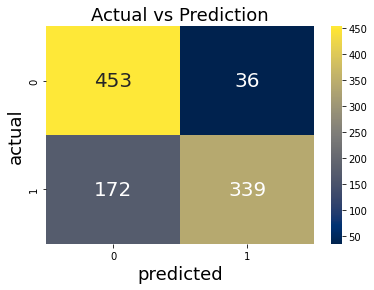

In [133]:
cm = confusion_matrix(df2['positive'], df2['prediction'])
sns.heatmap(cm, cmap= 'cividis', annot=True, fmt='g', annot_kws={'size':20})
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title('Actual vs Prediction', fontsize=18)

**Happy/Sad sentiments only achieved 79% Accuracy and AUC**
- we'll test Postive/Negative sentiments

In [ ]:
df3 = df2.copy

In [134]:
# Prediction method
def predict2(text):
    
    # Possible Sentiment Categories
    # Send the labels and text to the classifier pipeline
    candidate_labels = ['negative', 'positive']
    result = classifier(text, candidate_labels)
    
    # Extract first label (predicted sentiment)
    label = result['labels'][0]
    
    if label == 'positive':
        return 1
    else:
        return 0

    
df3 = df2.copy()

# Create prediction column on sample
df3['prediction'] = df3['text'].apply(predict2)

df3.head()

,positive,text,prediction
0,1,in panic in the streets richard widmark plays ...,0
1,0,if you ask me the first one was really better ...,0
2,1,i am a big fan a faerie tale theatre and i ve ...,1
3,0,i just finished reading a book about dillinger...,0
4,0,greg davis and bryan daly take some crazed sta...,0


In [135]:
roc_auc_score(df3['positive'], df3['prediction'])

0.8557781966471771

In [136]:
accuracy_score(df3['positive'], df3['prediction'])

0.854

Text(0.5, 1.0, 'Actual vs Prediction')

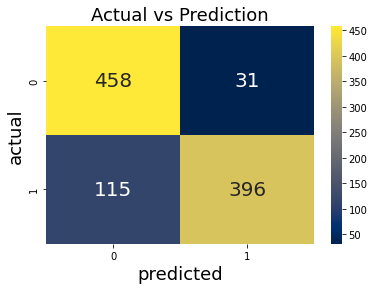

In [137]:
cm = confusion_matrix(df3['positive'], df3['prediction'])
sns.heatmap(cm, cmap= 'cividis',
            annot=True, fmt='g',
            annot_kws={'size':20},
            vmin= 0, vmax=df3.shape[0])
plt.xlabel('predicted', fontsize=18)
plt.ylabel('actual', fontsize=18)
plt.title('Actual vs Prediction', fontsize=18)

In [144]:
# Score confirmation
print(classification_report(df3['positive'], df3['prediction']))
print('AUC: ', round(roc_auc_score(df3['positive'], df3['prediction']), 2))

              precision    recall  f1-score   support

           0       0.80      0.94      0.86       489
           1       0.93      0.77      0.84       511

    accuracy                           0.85      1000
   macro avg       0.86      0.86      0.85      1000
weighted avg       0.86      0.85      0.85      1000

AUC:  0.86


**With the sample of 1000, stronger metrics were achieved with Negative/Positive sentiments**

In [29]:
# Prediction on full 25000 training dataset
X = df['text']
y = df['positive']
pred = X.apply(predict2) # utilizing negative/positive

print(classification_report(y, pred))
print('AUC: ', round(roc_auc_score(y, pred), 2))


# RESULTS SAVED DUE TO 2HOUR TRAINING TIME:
    #               precision    recall  f1-score   support

    #            0       0.80      0.94      0.87     12500
    #            1       0.93      0.77      0.84     12500

    #     accuracy                           0.86     25000
    #    macro avg       0.87      0.86      0.85     25000
    # weighted avg       0.87      0.86      0.85     25000

    # AUC:  0.86

              precision    recall  f1-score   support

           0       0.80      0.94      0.87     12500
           1       0.93      0.77      0.84     12500

    accuracy                           0.86     25000
   macro avg       0.87      0.86      0.85     25000
weighted avg       0.87      0.86      0.85     25000

AUC:  0.86


## RESULTS:
- virtually identical to the 1000-sample

In [54]:
# As per 2hrs+ training time, saved predictions for re-use
df['prediction'] = pred
df.to_csv('train_predicted.csv', index=False)

# RESULTS RECAP

**1. LOGISTIC REGRESSION + TF-IDF VECTORIZER**

<img src="../images/logreg_tfidf.png"
     alt="Logistic Regression Results"
     style="float: left;" />

**2. CONVOLUTIONAL NEURAL NETWORK (CNN) + GOOGLE WORD2VEC**

<img src="../images/cnn.png"
alt="Logistic Regression Results"
style="float: left;" />

**3. BIDIRECTIONAL AUTOREGRESSIVE TRANSFORMER (BART)**

<img src="../images/pretrained_BART.png"
alt="Logistic Regression Results"
style="float: left;" />

# NEXT STEPS
- Creating a 2-function web-app
    1. (simple) First function: analyze a user-input review to return:
        - minimum word count of 20 words
        - sentiment (positive/negative)
        - utilizing the trained CNN model
    2. (complex) Second function: analyze a users upload of reviews (.csv file) to return a full dashboard:
        - sentiment (positive/neutral/negative -- potentially more)
        - word cloud
        - top 5 words bar chart
        - overall rating (maybe, I'll need to create my own rating system based on the sentiment results)
        - recommendations based on overall result
        - utilizing the pre-trained BART model
        - table with a tally of reviews in 5 categories (will have to create algorithm for dividing the reviews)
            - Very Satisfied (80%+ positive)
            - Satisfied  (60-79.99% positive)
            - Neutral (50%+ neutral OR approx(+VE==-VE) )
                - 50%+ since it means neutral > sum(+VE,-VE)
                - approx(+VE==-VE) since there could be instances of 33% across all 3 sentiments or 40-50% +VE vs. 40-50% -VE with minimal neutral, but still means it's neutral as they're equally positive & negative
            - Unsatisfied (60-79.99% negative)
            - Very Unsatisfied (80%+ negative)

# WEB APP ROUGH CODE BLOCKS BELOW

In [38]:
import streamlit as st
import plotly.express as px

fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
fig.show()

# import plotly.graph_objects as go
# fig_widget = go.FigureWidget(fig)
# fig_widget

/home/kl/anaconda3/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning:

4.0.0-unsupported is an invalid version and will not be supported in a future release



In [3]:
# Sample code for loading large model (>50MB) from Google Drive
# For streamlit webapp
from pathlib import Path

save_dest = Path('model')
save_dest.mkdir(exist_ok=True)
model = Path('model/model.hdf5')
    # supposed to be Path('model/sentiment_model.hdf5')
    # but triggering gdrive_downloader with non-existing name

# If non-existent, download the model from google drive
if not model.exists():
    cloud_id = '1Nuc9NEX-CvGMe2w5TG_LrHTcipIWTIGs'
        # extracted from full URL "https://drive.google.com/file/d/1Nuc9NEX-CvGMe2w5TG_LrHTcipIWTIGs/view?usp=sharing"
    from gdrive_downloader import download_file_from_google_drive
    
    print("Downloading model...")
    download_file_from_google_drive(cloud_id, model)
    print('Download complete.')

Download complete.


In [84]:
# Loading fitted neural network tokenizer + trained neural network
from tensorflow.keras.models import load_model

with open('tokenizer/cnn_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
model = load_model(model)

In [107]:
sample_text = 'this is an amazing movie! We look forward to watching the next prequel.'
text_padded = pad_sequences(tokenizer.texts_to_sequences([sample_text]), 300)

pred = model.predict(text_padded)[0][0]
print(f'{round(pred*100,2)}% POSITIVE\n{round((1-pred)*100,2)}% NEGATIVE')
if pred > 0.5:
    print('Conclusion: POSITIVE REVIEW')
else:
    print('Conclusion: NEGATIVE REVIEW')

71.05% POSITIVE
28.95% NEGATIVE
Conclusion: POSITIVE REVIEW


In [5]:
import transformers
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [6]:
def sentiment(text):
    # Possible Sentiment Categories
    # Send the labels and text to the classifier pipeline
    candidate_labels = ["positive", "neutral", "negative"]
    result = classifier(text, candidate_labels)

    # Extract first label (predicted sentiment)
    label = result['labels'][0]

    if label == 'neutral':
        return 'neutral'
    elif label == 'positive':
        return 'positive'
    elif label == 'negative':
        return 'negative'

In [29]:
# Test
print(sentiment('That movie was okay. There were some good moments and some bad.'))
print(sentiment('That movies was good. The storyline unfolded wonderfully and the scenes were amazing.'))
print(sentiment('It movie was bad. The plot made no sense at all and I could barely watch the horrible film style.'))

neutral
positive
negative


In [35]:
sample_text1 = 'That movie was okay. There were some good moments and some bad.'
sample_text2 = 'That movies was good. The storyline unfolded wonderfully and the scenes were amazing.'
sample_text3 = 'It movie was bad. The plot made no sense at all and I could barely watch the horrible film style.'

candidate_labels = ["positive", "neutral", "negative"]
result = classifier(sample_text, candidate_labels)
print(result)

{'sequence': 'That movie was okay. There were some good moments and some bad.', 'labels': ['neutral', 'positive', 'negative'], 'scores': [0.5836620926856995, 0.3141263425350189, 0.10221154987812042]}


In [34]:
result = classifier(sample_text2, candidate_labels)
print(result)

{'sequence': 'That movies was good. The storyline unfolded wonderfully and the scenes were amazing.', 'labels': ['positive', 'neutral', 'negative'], 'scores': [0.9779980182647705, 0.017225855961441994, 0.0047760759480297565]}


In [36]:
result = classifier(sample_text3, candidate_labels)
print(result)

{'sequence': 'It movie was bad. The plot made no sense at all and I could barely watch the horrible film style.', 'labels': ['negative', 'neutral', 'positive'], 'scores': [0.9773865938186646, 0.018912961706519127, 0.0037004032637923956]}


In [2]:
# Clean text method
def cleaner(text):
    
    # Remove any HTML tags in-case
    text = BeautifulSoup(text).get_text()
    
    # Type and lower-cased
    text = str(text)
    text = text.lower()
    
    # Replace "n't" with " not"
        # Doesn’t, Isn’t, Wasn’t, Shouldn’t, Wouldn’t, Couldn’t, Won’t, Can’t, Don’t
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    
    # Join negatives "not" or "no" with next word
    text = re.sub("not ", " NOT", text)
    text = re.sub("no ", " NO", text)
    
    # Remove non-alphabets
    text = re.sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    
    # Extra cleaning beyond bs4
    text = re.sub(r"\+", " plus ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    return text

In [3]:
df = pd.read_csv('../datasets/unsup_50000.csv')
df_sample = df.sample(n=50, ignore_index=True)
df_sample.shape

(50, 1)

In [8]:
from tqdm import tqdm
tqdm.pandas()

df_sample['text'] = df_sample.text.progress_apply(cleaner)
df_sample['prediction'] = df_sample.text.progress_apply(sentiment)
df_sample.head()

100%|███████████████████████████████████████████| 50/50 [01:08<00:00,  1.38s/it]


,text,prediction
0,was that it ? linda mccartney was one of the b...,negative
1,i am second guessing myself over my 1 rating b...,negative
2,i do notnormally watch regular tv most of it t...,positive
3,normally the sight of carriages and bonnets on...,positive
4,it is neat to share in holmes american adventu...,positive


In [9]:
df_sample['prediction'].value_counts()

negative    34
positive    16
Name: prediction, dtype: int64

In [10]:
df_ordered = df_sample['prediction'].value_counts()
df_ordered

negative    34
positive    16
Name: prediction, dtype: int64

In [11]:
list(df_ordered.index)

['negative', 'positive']

In [12]:
list(df_ordered)

[34, 16]

In [93]:
ratios = list(df_sample['prediction'].value_counts(normalize=True))
ratios

[0.56, 0.44]

In [82]:
print(list(df_ordered.index))

['negative', 'positive']


In [86]:
from stqdm import stqdm

ModuleNotFoundError: No module named 'stqdm'

In [89]:
freq = list(df_ordered.prediction)
ratios = [n/sum(freq) for n in freq]

In [90]:
ratios

[0.56, 0.44]

In [84]:
print(list(df_ordered.prediction))

[28, 22]


In [140]:
import transformers
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [141]:
def sentiment(text):
    # Possible Sentiment Categories
    # Send the labels and text to the classifier pipeline
    result = classifier(text)

    # Extract first label (predicted sentiment)
    label = result[0]['label']
    
    return label

In [142]:
# Test
print(sentiment('That movie was okay. There were some good moments and some bad.'))
print(sentiment('That movies was good. The storyline unfolded wonderfully and the scenes were amazing.'))
print(sentiment('It movie was bad. The plot made no sense at all and I could barely watch the horrible film style.'))

LABEL_2
LABEL_2
LABEL_0


In [143]:
print(sentiment('amazing'))

LABEL_2


In [144]:
sample_text1 = 'That movie was okay. There were some bad moments.'
sample_text2 = 'That movies was good. The storyline unfolded wonderfully and the scenes were amazing.'
sample_text3 = 'It movie was bad. The plot made no sense at all and I could barely watch the horrible film style.'

result = classifier(sample_text1)
print(result)

[{'label': 'LABEL_2', 'score': 0.44948989152908325}]


In [145]:
candidate_labels = ['positive', 'neutral', 'negative']
result = classifier(sample_text2)
print(result)

[{'label': 'LABEL_2', 'score': 0.9891078472137451}]


In [146]:
result = classifier(sample_text3)
print(result)

[{'label': 'LABEL_0', 'score': 0.9815170168876648}]


In [17]:
cols = pd.DataFrame({"name":["a", "b", "c", "d"],
                   "value":[100,20,30,40],
                   "output":["YES", "NO", "BORDERLINE", "NO"]})

In [18]:
cols.head()

,name,value,output
0,a,100,YES
1,b,20,NO
2,c,30,BORDERLINE
3,d,40,NO


In [19]:
map_color = {"YES":"cyan", "NO":"pink", "BORDERLINE":"yellow"}
cols["color"] = 
cols.head()

,name,value,output,color
0,a,100,YES,cyan
1,b,20,NO,pink
2,c,30,BORDERLINE,yellow
3,d,40,NO,pink


In [27]:
len(cols.columns)

4

In [25]:
list(cols["output"].map(map_color))

['cyan', 'pink', 'yellow', 'pink']

In [23]:
cols_to_show = ['name','value','output']
fill_color = []
n = len(cols)

for col in cols_to_show:
    if col!='output':
        fill_color.append(['#e6f2fd']*n) # maybe try 'lavender'
    else:
        fill_color.append(cols["color"].to_list())
        
fill_color     

[['#e6f2fd', '#e6f2fd', '#e6f2fd', '#e6f2fd'],
 ['#e6f2fd', '#e6f2fd', '#e6f2fd', '#e6f2fd'],
 ['cyan', 'pink', 'yellow', 'pink']]

In [35]:
unsup = pd.read_csv('../datasets/unsup_50000.csv')

unsup_reduced = unsup.sample(35000, ignore_index=True)
unsup_reduced

,text
0,This movie is an entirely forgettable low-budg...
1,This is absolutely my favorite film of Robert ...
2,"This is just awful! Having seen the ""original""..."
3,"This story was so unbelievably corny, this is ..."
4,"""City of Men"" is a feature film version of a b..."
...,...
34995,"I absolutely loved this sequel to ""Ringu"". In ..."
34996,Great movie and easily Dennis Quaid's best wor...
34997,I paid to see this dog in an actual movie thea...
34998,"Yeah. ""The Pod People"" is a movie that is so e..."


In [36]:
unsup_reduced.to_csv('../datasets/movie_review_sample.csv', index=False)
